# Sentence Writing Scoring — Analysis & Methodology

**Project:** Marker Sentence Writing Pilot Test  
**Goal:** Automatically score whether a student used a target vocabulary word correctly in a sentence.  
**Approach:** LLM-based primary scorer + rule-based baseline, with inter-rater agreement as validation framework.

---

## Table of Contents
1. [Setup & Imports](#1-setup)
2. [Exploratory Data Analysis (EDA)](#2-eda)
3. [Rule-Based Scorer (Baseline)](#3-rule-based)
4. [LLM Scorer (Primary)](#4-llm)
5. [Comparison & Inter-Rater Agreement](#5-comparison)
6. [Validation Framework (Human Raters)](#6-validation)
7. [Results & Outputs](#7-results)

---
## 1. Setup & Imports <a id='1-setup'></a>

In [29]:
# Install dependencies if needed
%pip install spacy anthropic python-dotenv scikit-learn pandas matplotlib seaborn
%python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [ ]:
import os
import re
import json
import time
import asyncio
import random
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

import spacy
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report

import anthropic
from dotenv import load_dotenv

# Load API key from ../.env
load_dotenv(dotenv_path="../.env")

# ── Config ──────────────────────────────────────────────────────────────────
DATA_PATH   = "../data/raw/sentence_writing_test_data_unique_words.csv"
OUTPUT_PATH = "../outputs/scored_responses.csv"
SAMPLE_PATH = "../outputs/human_review_sample.csv"

# LLM settings
LLM_MODEL        = "claude-haiku-4-5-20251001"   # swap to claude-sonnet-4-6 for quality
MAX_TOKENS       = 300
CONCURRENCY      = 3                     # stay well under the 50 RPM concurrent cap
RATE_LIMIT_SLEEP = 0.3                   # seconds between calls (dry-run only)

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Anthropic clients
client       = anthropic.Anthropic()
async_client = anthropic.AsyncAnthropic(max_retries=6)  # auto backoff on 429s

# spaCy NLP pipeline
nlp = spacy.load("en_core_web_sm")

print("Setup complete.")
print(f"API key loaded: {'yes' if os.environ.get('ANTHROPIC_API_KEY') else 'NO — add key to ../.env'}")

Setup complete.
API key loaded: yes


---
## 2. Exploratory Data Analysis <a id='2-eda'></a>

In [30]:
df = pd.read_csv(DATA_PATH)
print(f"Shape: {df.shape}")
df.head(10)

Shape: (2179, 8)


,student_id,grade,age,gender,item_id,target_word,student_sentence,time_spent_seconds
0,1,4,9,Male,1,because,I am hapy because day.,35.57
1,1,4,9,Male,2,beautiful,I am hapy beautiful day.,25.33
2,1,4,9,Male,3,quickly,I am hapy quickly day.,36.53
3,1,4,9,Male,4,friend,I am hapy friend day.,35.19
4,1,4,9,Male,6,family,The family is fun.,21.16
5,1,4,9,Male,10,favorite,I am hapy favorite day.,22.30
6,1,4,9,Male,11,summer,I am hapy summer day.,26.47
7,1,4,9,Male,12,winter,I am hapy winter day.,30.80
8,1,4,9,Male,13,mountain,The mountain is fun.,26.00
9,1,4,9,Male,14,river,I am hapy river day.,22.75


In [53]:
# ── Data types & nulls ──────────────────────────────────────────────────────
print("=== dtypes ===")
print(df.dtypes)
print()
print("=== Null counts ===")
print(df.isnull().sum())

=== dtypes ===
student_id              int64
grade                   int64
age                     int64
gender                 object
item_id                 int64
target_word            object
student_sentence       object
time_spent_seconds    float64
suspicious_fast          bool
sentence_length         int64
is_template              bool
rb_score                int64
rb_confidence         float64
rb_reason              object
rb_word_found            bool
rb_pos_ok                bool
llm_score               int64
llm_confidence        float64
llm_reason             object
llm_error             float64
dtype: object

=== Null counts ===
student_id               0
grade                    0
age                      0
gender                   0
item_id                  0
target_word              0
student_sentence         0
time_spent_seconds       0
suspicious_fast          0
sentence_length          0
is_template              0
rb_score                 0
rb_confidence            0

In [54]:
# ── Dataset structure ───────────────────────────────────────────────────────
print(f"Students:        {df['student_id'].nunique()}")
print(f"Items (prompts): {df['item_id'].nunique()}")
print(f"Target words:    {df['target_word'].nunique()}")
print(f"Grade levels:    {sorted(df['grade'].unique())}")
print(f"Genders:         {df['gender'].unique().tolist()}")
print(f"Duplicate rows:  {df.duplicated(subset=['student_id','item_id']).sum()}")

Students:        50
Items (prompts): 60
Target words:    60
Grade levels:    [3, 4, 5, 6]
Genders:         ['Male', 'Female']
Duplicate rows:  0


Items attempted per student:
count    50.0
mean     43.6
std      10.7
min      25.0
25%      35.2
50%      43.5
75%      50.0
max      60.0
Name: item_id, dtype: float64


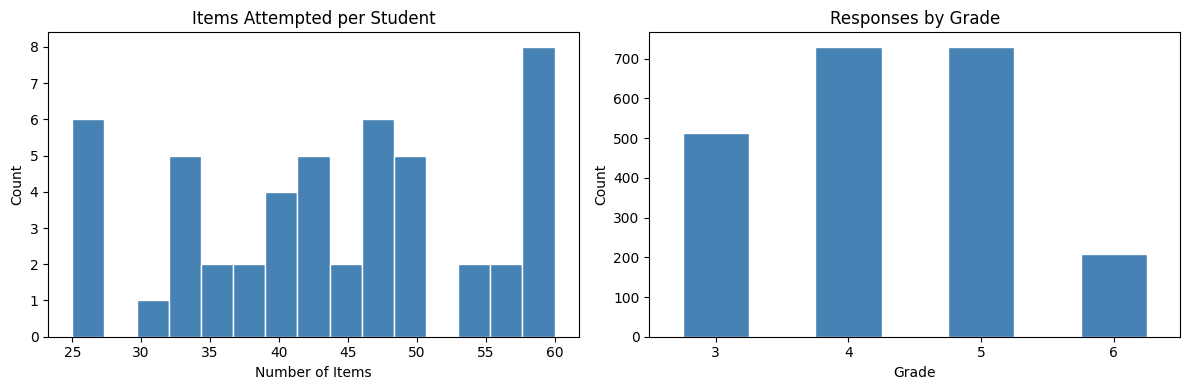

In [55]:
# ── Items per student (sparse design) ───────────────────────────────────────
items_per_student = df.groupby('student_id')['item_id'].count()
print("Items attempted per student:")
print(items_per_student.describe().round(1))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution of items per student
axes[0].hist(items_per_student, bins=15, edgecolor='white', color='steelblue')
axes[0].set_title('Items Attempted per Student')
axes[0].set_xlabel('Number of Items')
axes[0].set_ylabel('Count')

# Responses per grade
df.groupby('grade')['student_id'].count().plot(kind='bar', ax=axes[1], color='steelblue', edgecolor='white')
axes[1].set_title('Responses by Grade')
axes[1].set_xlabel('Grade')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
# plt.savefig('../outputs/eda_overview.png', dpi=150, bbox_inches='tight')
plt.show()

Time spent (seconds):
count    2179.00
mean       18.80
std         9.51
min         5.01
25%        10.99
50%        15.83
75%        25.24
max        39.80
Name: time_spent_seconds, dtype: float64

Responses under 5s (suspicious): 0


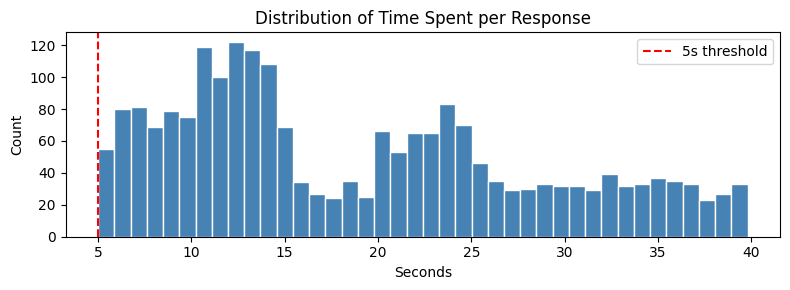

In [56]:
# ── Time-spent analysis ─────────────────────────────────────────────────────
print("Time spent (seconds):")
print(df['time_spent_seconds'].describe().round(2))

# Flag suspiciously fast responses (< 5s likely auto-fill or skipped)
FAST_THRESHOLD = 5
df['suspicious_fast'] = df['time_spent_seconds'] < FAST_THRESHOLD
print(f"\nResponses under {FAST_THRESHOLD}s (suspicious): {df['suspicious_fast'].sum()}")

plt.figure(figsize=(8,3))
plt.hist(df['time_spent_seconds'], bins=40, edgecolor='white', color='steelblue')
plt.axvline(FAST_THRESHOLD, color='red', linestyle='--', label=f'{FAST_THRESHOLD}s threshold')
plt.title('Distribution of Time Spent per Response')
plt.xlabel('Seconds')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
# plt.savefig('../outputs/eda_time.png', dpi=150, bbox_inches='tight')
plt.show()

In [57]:
# ── Sentence-level inspection ────────────────────────────────────────────────
df['sentence_length'] = df['student_sentence'].str.split().str.len()

print("Sentence length (words):")
print(df['sentence_length'].describe().round(1))

# Spot obvious template/boilerplate responses
template_patterns = [
    r"i used the word .+ correctly",
    r"i am hap[y|py] .+ day",
    r"i go to skool every day",
    r"my .+ is nice",
]
combined = '|'.join(template_patterns)
df['is_template'] = df['student_sentence'].str.lower().str.contains(combined, regex=True)
print(f"\nTemplate/boilerplate responses detected: {df['is_template'].sum()} "
      f"({df['is_template'].mean()*100:.1f}%)")

Sentence length (words):
count    2179.0
mean        6.4
std         2.2
min         4.0
25%         4.0
50%         5.0
75%         9.0
max         9.0
Name: sentence_length, dtype: float64

Template/boilerplate responses detected: 1933 (88.7%)


In [58]:
# ── EDA Summary ──────────────────────────────────────────────────────────────
print("=" * 60)
print("EDA SUMMARY")
print("=" * 60)
print(f"""
Dataset: {df.shape[0]:,} rows × {df.shape[1]} columns
Students: {df['student_id'].nunique()} — Grades 3–6
Items: {df['item_id'].nunique()} total; students attempt {items_per_student.mean():.0f} on average
Missing values: None
Duplicate (student, item) pairs: 0
Data types: All correct — no casting required

Quality flags:
  - Typos in sentences (e.g. 'hapy', 'skool'): expected, do NOT invalidate response
  - Template/boilerplate responses: {df['is_template'].sum()} ({df['is_template'].mean()*100:.1f}%) — likely incorrect use
  - Suspiciously fast responses (<{FAST_THRESHOLD}s): {df['suspicious_fast'].sum()}
  - All target words appear in their own sentences (surface match: 100%)
""")

EDA SUMMARY

Dataset: 2,179 rows × 20 columns
Students: 50 — Grades 3–6
Items: 60 total; students attempt 44 on average
Missing values: None
Duplicate (student, item) pairs: 0
Data types: All correct — no casting required

Quality flags:
  - Typos in sentences (e.g. 'hapy', 'skool'): expected, do NOT invalidate response
  - Template/boilerplate responses: 1933 (88.7%) — likely incorrect use
  - Suspiciously fast responses (<5s): 0
  - All target words appear in their own sentences (surface match: 100%)



---
## 3. Rule-Based Scorer (Baseline) <a id='3-rule-based'></a>

### Approach
A transparent NLP pipeline that scores each response on three criteria:

1. **Morphological check** — Is a valid inflected form of the target word present? (spaCy lemmatization)
2. **POS check** — Is the word used in a plausible grammatical role (not mid-sentence as wrong POS)?
3. **Template/boilerplate check** — Does the sentence appear to be a non-genuine placeholder?

Binary score = all checks pass. Confidence = weighted sum of sub-scores.

### Limitations
- Cannot assess semantic appropriateness (e.g., `"The tired jumped over the moon"` passes morphology + POS if `tired` is tagged as ADJ but used nonsensically)
- Struggles with creative or unusual but valid usage
- Typos in the target word itself (rare) would cause false negatives

In [59]:
# ── Acceptable POS tags per target word type ─────────────────────────────────
# Broad mapping: if a word can function as multiple POS, we allow all of them.
# spaCy coarse POS tags: NOUN, VERB, ADJ, ADV, ADP, CONJ/CCONJ, etc.

# We intentionally keep this permissive — a strict POS check would penalise
# legitimate creative usage and is better handled by the LLM scorer.
PERMISSIVE_POS = {'NOUN','VERB','ADJ','ADV','ADP','CCONJ','SCONJ','INTJ','PROPN'}


def lemma_match(token_lemma: str, target_word: str, nlp_model) -> bool:
    """Check if a spaCy token's lemma matches the lemma of the target word."""
    target_doc = nlp_model(target_word.lower())
    target_lemma = target_doc[0].lemma_ if target_doc else target_word.lower()
    return token_lemma.lower() == target_lemma.lower()


def rule_based_score(row: pd.Series, nlp_model, template_re) -> dict:
    """
    Score a single response using the rule-based pipeline.

    Returns a dict with:
        rb_score      : int   — 1 (correct) or 0 (incorrect)
        rb_confidence : float — confidence in [0, 1]
        rb_reason     : str   — brief explanation
        rb_word_found : bool  — whether a valid inflected form was present (Requirement 1)
        rb_pos_ok     : bool  — whether the word was used in a plausible POS role (Requirement 2)
    """
    sentence = str(row['student_sentence'])
    target   = str(row['target_word']).lower()

    # ── Check 1: Morphological presence (Requirement 1) ──────────────────────
    # Run this first so rb_word_found is accurate regardless of template status.
    doc = nlp_model(sentence)
    target_doc   = nlp_model(target)
    target_lemma = target_doc[0].lemma_.lower() if target_doc else target.lower()

    matched_tokens = [
        tok for tok in doc
        if tok.lemma_.lower() == target_lemma
        or tok.text.lower() == target.lower()
    ]
    word_found = len(matched_tokens) > 0

    # ── Check 2: Template/boilerplate ────────────────────────────────────────
    # Score is 0 regardless of word presence — template sentences demonstrate
    # no understanding. rb_word_found still reflects actual morphological presence.
    if template_re.search(sentence.lower()):
        return {
            'rb_score':      0,
            'rb_confidence': 0.90,
            'rb_reason':     'Template/boilerplate sentence detected',
            'rb_word_found': word_found,
            'rb_pos_ok':     False,   # POS irrelevant in template context
        }

    if not word_found:
        return {
            'rb_score':      0,
            'rb_confidence': 0.85,
            'rb_reason':     'Target word (or inflected form) not found in sentence',
            'rb_word_found': False,
            'rb_pos_ok':     False,
        }

    # ── Check 3: POS plausibility (Requirement 2 — grammatical) ──────────────
    token  = matched_tokens[0]
    pos_ok = token.pos_ in PERMISSIVE_POS

    # ── Check 4: Minimal content — is the sentence more than just the word? ──
    content_ok = len([t for t in doc if not t.is_punct and not t.is_space]) > 1

    # ── Confidence calculation ────────────────────────────────────────────────
    conf_components = {
        'morphology':  1.0,
        'pos_ok':      0.80 if pos_ok else 0.30,
        'content_ok':  0.80 if content_ok else 0.20,
    }
    weights    = {'morphology': 0.4, 'pos_ok': 0.35, 'content_ok': 0.25}
    confidence = sum(conf_components[k] * weights[k] for k in weights)

    rb_score = 1 if (pos_ok and content_ok) else 0

    reason_parts = []
    if not pos_ok:     reason_parts.append(f"unexpected POS tag '{token.pos_}'")
    if not content_ok: reason_parts.append("sentence contains only the target word")
    reason = ", ".join(reason_parts) if reason_parts else "Word present with plausible POS and content"

    return {
        'rb_score':      rb_score,
        'rb_confidence': round(confidence, 3),
        'rb_reason':     reason,
        'rb_word_found': True,
        'rb_pos_ok':     pos_ok,
    }

In [60]:
# ── Run rule-based scorer ─────────────────────────────────────────────────────
template_re = re.compile(
    r"i used the word .+ correctly"
    r"|i am hap[y|py] .+ day"
    r"|i go to skool every day"
    r"|my .+ is nice",
    re.IGNORECASE
)

RB_COLS = ['rb_score', 'rb_confidence', 'rb_reason', 'rb_word_found', 'rb_pos_ok']
rb_results = df.apply(lambda row: rule_based_score(row, nlp, template_re), axis=1)
rb_df = pd.DataFrame(rb_results.tolist())
df = df.drop(columns=[c for c in RB_COLS if c in df.columns])
df = pd.concat([df, rb_df], axis=1)

print("Rule-based scoring complete.")
print(f"Score distribution:\n{df['rb_score'].value_counts()}")
print(f"\nMean confidence: {df['rb_confidence'].mean():.3f}")

Rule-based scoring complete.
Score distribution:
rb_score
0    1933
1     246
Name: count, dtype: int64

Mean confidence: 0.898


In [61]:
# ── Inspect rule-based results ───────────────────────────────────────────────
print("=== Sample CORRECT (rule-based) ===")
display(df[df['rb_score']==1][['target_word','student_sentence','rb_confidence','rb_reason']].sample(5, random_state=42))

print("\n=== Sample INCORRECT (rule-based) ===")
display(df[df['rb_score']==0][['target_word','student_sentence','rb_confidence','rb_reason']].sample(5, random_state=42))

=== Sample CORRECT (rule-based) ===


,target_word,student_sentence,rb_confidence,rb_reason
177,island,The island is fun.,0.88,Word present with plausible POS and content
29,village,The village is fun.,0.88,Word present with plausible POS and content
1577,earth,The earth is fun.,0.88,Word present with plausible POS and content
531,island,The island is fun.,0.88,Word present with plausible POS and content
1517,snow,The snow is fun.,0.88,Word present with plausible POS and content



=== Sample INCORRECT (rule-based) ===


,target_word,student_sentence,rb_confidence,rb_reason
1228,ocean,I go to skool every day ocean.,0.9,Template/boilerplate sentence detected
1868,airplane,My airplane is nice.,0.9,Template/boilerplate sentence detected
2097,ocean,I used the word ocean correctly in this sentence.,0.9,Template/boilerplate sentence detected
1081,tennis,I used the word tennis correctly in this sente...,0.9,Template/boilerplate sentence detected
391,happy,I am hapy happy day.,0.9,Template/boilerplate sentence detected


---
## 4. LLM Scorer (Primary) <a id='4-llm'></a>

### Approach
We send each (target_word, student_sentence, grade) tuple to Claude with a structured prompt that asks the model to evaluate:

1. Whether a valid inflected form of the target word is present
2. Whether the word is used grammatically correctly
3. Whether the word is used with appropriate meaning/semantics

The model returns a JSON response with:
- `score` — 1 (correct) or 0 (incorrect)
- `confidence` — float in [0, 1]
- `reason` — brief natural-language explanation

### Design decisions
- **Grade-awareness:** We pass the grade level so the model calibrates expectations (a grade 3 sentence is judged differently than grade 6)
- **Typo tolerance:** The prompt explicitly instructs the model to ignore typos in surrounding words — only the target word usage matters
- **Strict JSON output:** We parse the response and fall back gracefully on parse errors
- **Batching:** A small sleep between calls respects rate limits

In [62]:
SYSTEM_PROMPT = """\
You are an expert educational psychologist scoring a vocabulary sentence-writing test for elementary school students (grades 3–6).

Your task is to judge whether a student correctly used a given TARGET WORD in their sentence.

Scoring criteria — a sentence is CORRECT (score=1) if ALL of the following hold:
1. A valid inflected form of the target word is present (e.g. run/ran/running all count for target 'run').
2. The word is used in a grammatically plausible role (noun as noun, verb as verb, etc.).
3. The word is used with appropriate meaning — the sentence demonstrates understanding of the word.

A sentence is INCORRECT (score=0) if ANY of the following:
- The target word is absent or only present as part of a different word.
- The word is used in a semantically meaningless or nonsensical way (e.g. "I am tired mountain").
- The sentence is a boilerplate placeholder (e.g. "I used the word X correctly in this sentence").
- The word is used as the wrong part of speech in a way that indicates misunderstanding.

Important:
- IGNORE typos and spelling errors in the rest of the sentence — only judge usage of the TARGET WORD.
- Be appropriately lenient for the student's grade level. A short simple sentence from grade 3 can still be correct.
- Do not penalise for stylistic simplicity or imperfect grammar if the target word is correctly used.

Respond ONLY with valid JSON in this exact format (no preamble, no markdown):
{"score": 0 or 1, "confidence": float between 0 and 1, "reason": "brief explanation"}
"""


def build_user_prompt(target_word: str, sentence: str, grade: int) -> str:
    return (
        f"Grade: {grade}\n"
        f"Target word: {target_word}\n"
        f"Student sentence: {sentence}"
    )


def llm_score_row(row: pd.Series, client, model: str, max_tokens: int) -> dict:
    """
    Call the LLM to score a single response.
    Returns a dict with llm_score, llm_confidence, llm_reason.
    """
    user_prompt = build_user_prompt(
        target_word = str(row['target_word']),
        sentence    = str(row['student_sentence']),
        grade       = int(row['grade'])
    )

    try:
        response = client.messages.create(
            model      = model,
            max_tokens = max_tokens,
            system     = SYSTEM_PROMPT,
            messages   = [{"role": "user", "content": user_prompt}]
        )
        raw = response.content[0].text.strip()

        # Strip markdown fences if present
        raw = re.sub(r'^```json\s*|```$', '', raw, flags=re.MULTILINE).strip()
        parsed = json.loads(raw)

        return {
            'llm_score':      int(parsed.get('score', 0)),
            'llm_confidence': float(parsed.get('confidence', 0.5)),
            'llm_reason':     str(parsed.get('reason', '')),
            'llm_error':      None
        }

    except json.JSONDecodeError as e:
        return {
            'llm_score':      -1,
            'llm_confidence': 0.0,
            'llm_reason':     f'JSON parse error: {raw[:100]}',
            'llm_error':      str(e)
        }
    except Exception as e:
        return {
            'llm_score':      -1,
            'llm_confidence': 0.0,
            'llm_reason':     'API error',
            'llm_error':      str(e)
        }


print("LLM scorer defined.")

LLM scorer defined.


In [63]:
# ── Dry-run: test the LLM scorer on 3 examples before full run ───────────────
test_rows = df.sample(3, random_state=RANDOM_SEED)

for _, row in test_rows.iterrows():
    result = llm_score_row(row, client, LLM_MODEL, MAX_TOKENS)
    print(f"Target: '{row['target_word']}'  |  Sentence: '{row['student_sentence']}'")
    print(f"  → score={result['llm_score']}  confidence={result['llm_confidence']:.2f}  reason={result['llm_reason']}")
    if result.get('llm_error'):
        print(f"  → ERROR: {result['llm_error']}")
    print()
    time.sleep(RATE_LIMIT_SLEEP)

Target: 'friend'  |  Sentence: 'The friend is fun.'
  → score=1  confidence=0.99  reason=The word 'friend' is used correctly as a noun in its base form. The sentence is grammatically plausible and demonstrates understanding of the word's meaning. Simple but appropriate for grade 5.

Target: 'pencil'  |  Sentence: 'I go to skool every day pencil.'
  → score=0  confidence=0.99  reason=The word 'pencil' is used in a semantically meaningless way. It appears at the end of the sentence with no grammatical function or logical connection to the rest of the sentence ('I go to school every day pencil' does not make sense). The student has not demonstrated understanding of how to use 'pencil' as a noun in a meaningful context.

Target: 'desert'  |  Sentence: 'I used the word desert correctly in this sentence.'
  → score=0  confidence=0.99  reason=This is a boilerplate placeholder sentence that does not actually use the target word 'desert' in a meaningful way. It only mentions the word in referen

In [64]:
# ── Pre-run alignment check ───────────────────────────────────────────────────
# Scores 5 rows synchronously and confirms llm_reason mentions the target_word.
# Run this before the full scoring cell to catch any prompt/wiring issues cheaply.

sample = df.sample(5, random_state=RANDOM_SEED)
print("Alignment check — confirming target_word appears in llm_reason:\n")
for idx, row in sample.iterrows():
    result = llm_score_row(row, client, LLM_MODEL, MAX_TOKENS)
    target  = row['target_word'].lower()
    aligned = target in result['llm_reason'].lower()
    flag    = "OK      " if aligned else "MISMATCH"
    print(f"[{flag}] idx={idx}  target='{target}'")
    print(f"          sentence: {row['student_sentence']}")
    print(f"          reason:   {result['llm_reason'][:100]}")
    print()
    time.sleep(RATE_LIMIT_SLEEP)

Alignment check — confirming target_word appears in llm_reason:

[OK      ] idx=282  target='friend'
          sentence: The friend is fun.
          reason:   The target word 'friend' is present and used correctly as a noun in its standard form. The sentence 

[OK      ] idx=479  target='pencil'
          sentence: I go to skool every day pencil.
          reason:   The target word 'pencil' is used in a semantically meaningless way. It appears appended to the sente

[OK      ] idx=1307  target='desert'
          sentence: I used the word desert correctly in this sentence.
          reason:   This is a boilerplate placeholder sentence that does not actually use the target word 'desert' in a 

[OK      ] idx=1254  target='winter'
          sentence: I used the word winter correctly in this sentence.
          reason:   This is a boilerplate placeholder sentence that does not demonstrate actual use of the target word. 

[OK      ] idx=507  target='beautiful'
          sentence: I am hapy

In [65]:
# ── Async LLM scoring ────────────────────────────────────────────────────────

async def llm_score_row_async(idx: int, row: pd.Series, semaphore: asyncio.Semaphore) -> dict:
    """Score a single row asynchronously. Returns result with original df index."""
    async with semaphore:
        user_prompt = build_user_prompt(
            target_word = str(row['target_word']),
            sentence    = str(row['student_sentence']),
            grade       = int(row['grade'])
        )
        try:
            response = await async_client.messages.create(
                model      = LLM_MODEL,
                max_tokens = MAX_TOKENS,
                system     = SYSTEM_PROMPT,
                messages   = [{"role": "user", "content": user_prompt}]
            )
            raw    = response.content[0].text.strip()
            raw    = re.sub(r'^```json\s*|```$', '', raw, flags=re.MULTILINE).strip()
            parsed = json.loads(raw)
            return {
                'original_index': idx,
                'llm_score':      int(parsed.get('score', 0)),
                'llm_confidence': float(parsed.get('confidence', 0.5)),
                'llm_reason':     str(parsed.get('reason', '')),
                'llm_error':      None
            }
        except json.JSONDecodeError as e:
            return {'original_index': idx, 'llm_score': -1, 'llm_confidence': 0.0,
                    'llm_reason': f'JSON parse error: {raw[:100]}', 'llm_error': str(e)}
        except Exception as e:
            return {'original_index': idx, 'llm_score': -1, 'llm_confidence': 0.0,
                    'llm_reason': 'API error', 'llm_error': str(e)}


async def score_all_async(rows: pd.DataFrame) -> list[dict]:
    """Fire requests concurrently, capped at CONCURRENCY simultaneous calls."""
    semaphore = asyncio.Semaphore(CONCURRENCY)
    tasks     = [llm_score_row_async(idx, row, semaphore) for idx, row in rows.iterrows()]
    total     = len(tasks)
    results   = []

    for i, coro in enumerate(asyncio.as_completed(tasks)):
        result = await coro
        results.append(result)
        if (i + 1) % 100 == 0:
            print(f"  Scored {i+1}/{total}...")

    return results


# ── Run (or resume from cache) ───────────────────────────────────────────────
# NOTE: For larger datasets (10k+ rows), consider the Anthropic Batches API instead.
# It bypasses per-minute rate limits, costs 50% less, and processes jobs asynchronously.
# See: https://docs.anthropic.com/en/docs/build-with-claude/message-batches

RUN_FULL_LLM = False   # Set to True to re-score (will retry only failed rows if cache exists)
LLM_CACHE    = "../outputs/llm_scores_cache.csv"
LLM_COLS     = ['llm_score', 'llm_confidence', 'llm_reason', 'llm_error']

if RUN_FULL_LLM:
    if os.path.exists(LLM_CACHE):
        cached_df  = pd.read_csv(LLM_CACHE, index_col='original_index')
        failed_idx = cached_df[cached_df['llm_score'] == -1].index
        todo_df    = df.loc[failed_idx].copy()
        keep_df    = cached_df[cached_df['llm_score'] != -1].copy()
        print(f"Cache found — {len(keep_df)} good, {len(todo_df)} to retry")
    else:
        todo_df = df.copy()
        keep_df = pd.DataFrame()
        print(f"No cache — scoring all {len(todo_df)} rows")

    if len(todo_df) > 0:
        start       = time.time()
        new_results = await score_all_async(todo_df)
        elapsed     = time.time() - start

        new_df = pd.DataFrame(new_results).set_index('original_index')
        llm_df = pd.concat([keep_df, new_df])
        llm_df.to_csv(LLM_CACHE)   # original_index saved as the index column
        print(f"\nDone — {len(todo_df)} rows in {elapsed:.1f}s  ({elapsed/len(todo_df)*1000:.0f}ms/row)")
        print(f"Cached to {LLM_CACHE}")
    else:
        llm_df = keep_df
        print("Nothing to re-score.")

else:
    llm_df = pd.read_csv(LLM_CACHE, index_col='original_index')
    print(f"Loaded cached LLM scores from {LLM_CACHE}")

# Join on index — rows always align correctly regardless of cache/retry order
df = df.drop(columns=[c for c in LLM_COLS if c in df.columns])
df = df.join(llm_df[LLM_COLS])

errors = df[df['llm_score'] == -1]
print(f"\nAPI errors: {len(errors)} rows")

Loaded cached LLM scores from ../outputs/llm_scores_cache.csv

API errors: 0 rows


In [66]:
# ── Post-run alignment check ──────────────────────────────────────────────────
# Checks that llm_reason mentions the target_word for a sample of scored rows.
# LLMs don't always echo the word explicitly, so expect ~70–90% — below 50% signals misalignment.

valid_check = df[df['llm_score'].isin([0, 1])].copy()
valid_check['reason_mentions_target'] = valid_check.apply(
    lambda r: str(r['target_word']).lower() in str(r['llm_reason']).lower(), axis=1
)
match_rate = valid_check['reason_mentions_target'].mean()
print(f"Rows where llm_reason mentions target_word: {match_rate*100:.1f}%")
print("(Expect ~70–90% — if below 50%, scores are likely misaligned)\n")

mismatches = valid_check[~valid_check['reason_mentions_target']]
print(f"Rows where target not mentioned in reason: {len(mismatches)}")
display(mismatches[['target_word', 'student_sentence', 'llm_reason']].head(5))

Rows where llm_reason mentions target_word: 91.4%
(Expect ~70–90% — if below 50%, scores are likely misaligned)

Rows where target not mentioned in reason: 187


,target_word,student_sentence,llm_reason
47,animal,I used the word animal correctly in this sente...,This is a boilerplate placeholder sentence tha...
48,garden,I used the word garden correctly in this sente...,This is a boilerplate placeholder sentence tha...
51,tired,I used the word tired correctly in this sentence.,This is a boilerplate placeholder sentence tha...
52,excited,I used the word excited correctly in this sent...,This is a boilerplate placeholder sentence tha...
55,birthday,I used the word birthday correctly in this sen...,This is a boilerplate placeholder sentence tha...


---
## 5. Comparison & Inter-Rater Agreement <a id='5-comparison'></a>

We treat the rule-based scorer and LLM scorer as two independent "raters" and compute:
- **Cohen's Kappa** — agreement adjusted for chance
- **Raw agreement rate** — simple % match
- **Confusion matrix** — to identify direction of disagreements
- **Disagreement cases** — the most informative rows for human review

In [67]:
# ── Filter to valid LLM scores only ─────────────────────────────────────────
valid = df[df['llm_score'].isin([0, 1])].copy()
print(f"Valid rows for comparison: {len(valid)} / {len(df)}")

rb  = valid['rb_score'].astype(int)
llm = valid['llm_score'].astype(int)

# ── Agreement metrics ────────────────────────────────────────────────────────
agreement_rate = (rb == llm).mean()
kappa          = cohen_kappa_score(rb, llm)

print(f"\nRaw agreement:  {agreement_rate:.3f} ({agreement_rate*100:.1f}%)")
print(f"Cohen's Kappa:  {kappa:.3f}")
print()

# Kappa interpretation
if   kappa < 0.20: interp = "Slight"
elif kappa < 0.40: interp = "Fair"
elif kappa < 0.60: interp = "Moderate"
elif kappa < 0.80: interp = "Substantial"
else:              interp = "Almost Perfect"
print(f"Kappa interpretation: {interp}")

Valid rows for comparison: 2179 / 2179

Raw agreement:  0.858 (85.8%)
Cohen's Kappa:  0.510

Kappa interpretation: Moderate


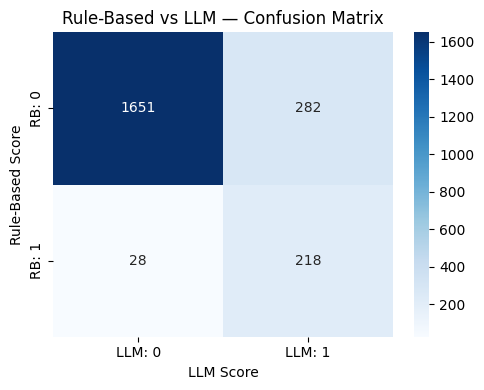

Both correct (agree=1):           218
Both incorrect (agree=0):         1651
RB=0, LLM=1 (LLM more lenient):    282
RB=1, LLM=0 (RB more lenient):      28


In [68]:
# ── Confusion matrix: RB vs LLM ───────────────────────────────────────────────
cm = confusion_matrix(rb, llm)

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['LLM: 0', 'LLM: 1'],
    yticklabels=['RB: 0',  'RB: 1'],
    ax=ax
)
ax.set_title('Rule-Based vs LLM — Confusion Matrix')
ax.set_ylabel('Rule-Based Score')
ax.set_xlabel('LLM Score')
plt.tight_layout()
# plt.savefig('outputs/confusion_rb_vs_llm.png', dpi=150, bbox_inches='tight')
plt.show()

# Label disagreement quadrants
tn, fp, fn, tp = cm.ravel()
print(f"Both correct (agree=1):         {tp:>5}")
print(f"Both incorrect (agree=0):        {tn:>5}")
print(f"RB=0, LLM=1 (LLM more lenient):  {fp:>5}")
print(f"RB=1, LLM=0 (RB more lenient):   {fn:>5}")

---
## 6. Validation Framework (Human Raters) <a id='6-validation'></a>

### Strategy

The automated scorers are validated against expert human judgments using a three-phase cycle: **sample → evaluate → refine**.

---

### Phase 1 — Stratified Sample Selection

Select ~120–150 responses for human rating, covering all four agreement quadrants:

| Quadrant | Meaning | Why include |
|---|---|---|
| Both agree correct | High-confidence correct | Confirm true positives |
| Both agree incorrect | High-confidence incorrect | Confirm true negatives |
| RB=0, LLM=1 | LLM more lenient | Resolve disagreements |
| RB=1, LLM=0 | RB more lenient | Resolve disagreements |

Stratify further by grade level and target word so no single subgroup dominates. The code below generates this sample automatically.

**Inter-rater reliability between human raters:** If two or more human raters score the same items, compute their pairwise Cohen's Kappa before treating any labels as ground truth. A Kappa below 0.60 indicates the scoring rubric needs clarification. Adjudicate conflicts by majority vote or a third rater; only use resolved labels downstream.

---

### Phase 2 — Evaluate Each Scorer Against Human Ground Truth

For each scorer (rule-based, LLM), compute against the human-adjudicated labels:

- **Cohen's Kappa** — primary agreement metric, chance-adjusted
- **Precision / Recall / F1** — separately for correct (1) and incorrect (0) classes
- **Confusion matrix** — identifies direction of systematic bias (over-lenient vs. over-strict)

Interpretation benchmarks:
- Kappa ≥ 0.80 → substantial agreement, scorer is production-ready
- Kappa 0.60–0.79 → moderate agreement, targeted prompt/rule refinement needed
- Kappa < 0.60 → systematic failure, major revision required

---

### Phase 3 — Refine the Algorithm

**Rule-based refinements** (for systematic rule failures):
- Add missed template patterns identified in the failure analysis
- Adjust POS tag allowlist if certain word classes are consistently mistagged

**LLM prompt refinements** (for semantic/contextual failures):
1. From the disagreement cases, select the most instructive examples (3–5 per failure mode)
2. Add them as few-shot examples in the system prompt, labelled with correct scores and reasons
3. Re-score the human-labelled sample with the updated prompt
4. Recompute Kappa — accept the change only if Kappa improves by ≥ 0.03

**Stopping criterion:** Iterate until Kappa ≥ 0.80 on the human-labelled set, or until marginal gains fall below 0.02 per iteration.

**Longer-term — fine-tuned classifier:** As labelled examples accumulate (target: ~500+), the LLM can be replaced by a fine-tuned encoder model (e.g., DeBERTa-v3-base) trained directly on the adjudicated labels. This eliminates API costs and rate-limit constraints while maintaining accuracy.

The code below generates the human review sample CSV, ready to send to raters.

In [69]:
# ── Disagreement cases — highest value for human review ──────────────────────
disagreements = valid[rb != llm][[
    'student_id','grade','target_word','student_sentence',
    'rb_score','rb_confidence','rb_reason',
    'llm_score','llm_confidence','llm_reason'
]].copy()
disagreements['disagreement_type'] = disagreements.apply(
    lambda r: 'RB=0, LLM=1' if r['rb_score']==0 and r['llm_score']==1 else 'RB=1, LLM=0',
    axis=1
)

print(f"Total disagreements: {len(disagreements)}")
print(disagreements['disagreement_type'].value_counts())

print("\n=== Sample RB=0, LLM=1 (LLM more lenient) ===")
display(disagreements[disagreements['disagreement_type']=='RB=0, LLM=1'][
    ['grade','target_word','student_sentence','rb_reason','llm_reason']
].head(5))

print("\n=== Sample RB=1, LLM=0 (RB more lenient) ===")
display(disagreements[disagreements['disagreement_type']=='RB=1, LLM=0'][
    ['grade','target_word','student_sentence','rb_reason','llm_reason']
].head(5))

Total disagreements: 310
disagreement_type
RB=0, LLM=1    282
RB=1, LLM=0     28
Name: count, dtype: int64

=== Sample RB=0, LLM=1 (LLM more lenient) ===


,grade,target_word,student_sentence,rb_reason,llm_reason
80,4,quickly,I go to skool every day quickly.,Template/boilerplate sentence detected,The adverb 'quickly' is correctly used to modi...
81,4,friend,My friend is nice.,Template/boilerplate sentence detected,The word 'friend' is used correctly as a noun ...
82,4,school,My school is nice.,Template/boilerplate sentence detected,The target word 'school' is present as a noun ...
83,4,animal,My animal is nice.,Template/boilerplate sentence detected,The word 'animal' is used correctly as a noun ...
84,4,garden,My garden is nice.,Template/boilerplate sentence detected,The target word 'garden' is used correctly as ...



=== Sample RB=1, LLM=0 (RB more lenient) ===


,grade,target_word,student_sentence,rb_reason,llm_reason
121,3,excited,The excited is fun.,Word present with plausible POS and content,The word 'excited' is used as a noun here ('Th...
145,3,breakfast,The breakfast is fun.,Word present with plausible POS and content,The word 'breakfast' is used as a noun (the me...
147,3,chocolate,The chocolate is fun.,Word present with plausible POS and content,The word 'chocolate' is present and used as a ...
164,5,because,The because is fun.,Word present with plausible POS and content,"The target word 'because' is a conjunction, no..."
281,5,beautiful,The beautiful is fun.,Word present with plausible POS and content,The word 'beautiful' is used as a noun ('The b...


---
## 6. Validation Framework (Human Raters) <a id='6-validation'></a>

### Strategy
When human rater labels become available, we follow this process:

**Step 1 — Stratified sample selection**  
Select ~150–200 responses for human rating, stratified by:
- Agreement quadrant (both agree correct, both agree incorrect, each type of disagreement) — ensures all edge cases are represented
- Grade level — ensures coverage across the population
- Target word — ensures no single word dominates the sample

**Step 2 — Compute agreement metrics**  
For each scorer vs. human: Cohen's Kappa, precision/recall/F1 (treating human as ground truth)

**Step 3 — Failure mode analysis**  
For cases where an automated scorer disagrees with the human:
- Cluster by reason type (template detection error, POS mistagging, LLM hallucination, etc.)
- Identify systematic biases (e.g., LLM consistently too lenient on grade 3)

**Step 4 — Iterate**  
- Rule-based: adjust template patterns, POS rules
- LLM: update system prompt with few-shot examples drawn from the disagreement cases
- Accumulate labels → eventually fine-tune a smaller model to replace the LLM

The code below generates a ready-to-use human review sample.

In [70]:
def build_human_review_sample(
    df: pd.DataFrame,
    rb_col: str = 'rb_score',
    llm_col: str = 'llm_score',
    n_per_quadrant: int = 30,
    seed: int = RANDOM_SEED
) -> pd.DataFrame:
    """
    Build a stratified human-review sample covering all four agreement quadrants.
    Adds a blank 'human_score' column for raters to fill in.
    """
    valid = df[df[llm_col].isin([0, 1])].copy()

    quadrants = {
        'agree_correct':    (valid[rb_col]==1) & (valid[llm_col]==1),
        'agree_incorrect':  (valid[rb_col]==0) & (valid[llm_col]==0),
        'rb0_llm1':         (valid[rb_col]==0) & (valid[llm_col]==1),
        'rb1_llm0':         (valid[rb_col]==1) & (valid[llm_col]==0),
    }

    frames = []
    for label, mask in quadrants.items():
        subset = valid[mask].copy()
        n = min(n_per_quadrant, len(subset))
        sampled = subset.sample(n, random_state=seed)
        sampled['quadrant'] = label
        frames.append(sampled)
        print(f"  {label}: {n} rows sampled (available: {len(subset)})")

    sample = pd.concat(frames, ignore_index=True)
    sample['human_score'] = ''   # blank for raters
    sample['human_notes'] = ''   # optional notes

    cols = [
        'student_id','grade','target_word','student_sentence','time_spent_seconds',
        'rb_score','rb_confidence','rb_reason',
        'llm_score','llm_confidence','llm_reason',
        'quadrant','human_score','human_notes'
    ]
    return sample[[c for c in cols if c in sample.columns]]


print("Building human review sample...")
review_sample = build_human_review_sample(df)
review_sample.to_csv(SAMPLE_PATH, index=False)
print(f"\nHuman review sample saved to: {SAMPLE_PATH}")
print(f"Total rows: {len(review_sample)}")

Building human review sample...
  agree_correct: 30 rows sampled (available: 218)
  agree_incorrect: 30 rows sampled (available: 1651)
  rb0_llm1: 30 rows sampled (available: 282)
  rb1_llm0: 28 rows sampled (available: 28)

Human review sample saved to: ../outputs/human_review_sample.csv
Total rows: 118


In [71]:
# ── Validation analysis — run this AFTER human labels are collected ──────────
# Uncomment and run once human_score column is filled in

# labeled = pd.read_csv(SAMPLE_PATH)
# labeled = labeled[labeled['human_score'].isin([0, 1])]
# human = labeled['human_score'].astype(int)

# for scorer_col, label in [('rb_score', 'Rule-Based'), ('llm_score', 'LLM')]:
#     preds = labeled[scorer_col].astype(int)
#     kappa = cohen_kappa_score(human, preds)
#     print(f"\n=== {label} vs Human ===")
#     print(f"Cohen's Kappa: {kappa:.3f}")
#     print(classification_report(human, preds, target_names=['Incorrect','Correct']))

print("(Validation analysis awaiting human labels — see comments above)")

(Validation analysis awaiting human labels — see comments above)


---
## 7. Results & Outputs <a id='7-results'></a>

---
## Methodology Write-Up

### Algorithm Design

The scoring task requires three capabilities, each addressed explicitly:

**Requirement 1 — Verify the presence of a validly inflected form**

The rule-based scorer uses spaCy's lemmatization pipeline to check whether a morphological variant of the target word appears in the student's sentence. For example, *ran*, *running*, and *runs* all match the target *run* via their shared lemma. A direct surface-form match is also accepted as a fallback. This check is fast, fully deterministic, and runs on every response before any API call is made.

**Requirement 2 — Assess grammatical and semantic appropriateness**

Grammatical appropriateness is partially assessed by the rule-based scorer via Part-of-Speech (POS) tagging: the matched token must appear in a plausible grammatical role (noun, verb, adjective, etc.). However, POS tags cannot detect semantic misuse — a word can appear in the right grammatical role while being used nonsensically. Semantic appropriateness is therefore handled by the LLM scorer (Claude), which is instructed to evaluate whether the sentence demonstrates genuine understanding of the word's meaning, accounting for grade-level expectations and ignoring unrelated spelling errors.

The two-scorer design is intentional: the rule-based scorer provides a fast, interpretable baseline that catches mechanical failures (word absent, boilerplate sentence), while the LLM handles the harder semantic and contextual judgments that rule-based systems cannot reliably make.

**Requirement 3 — Produce a binary score and confidence score**

Both scorers return:
- A **binary score**: 1 (correct) or 0 (incorrect)
- A **confidence score** in [0, 1]

For the rule-based scorer, confidence is a weighted sum of three sub-check outcomes (morphology: 40%, POS plausibility: 35%, content beyond single word: 25%), producing values that reflect how many checks passed and how strongly. For the LLM scorer, confidence is the model's own calibrated self-assessment, which tends to be high (>0.90) on clear-cut cases and lower on genuinely ambiguous ones.

The **final score** uses the LLM as the primary rater, with the rule-based score as a cross-check. Cases where the two scorers disagree, or where LLM confidence is below 0.70, are flagged for human review.

---

### Assumptions

- **Typo tolerance:** Spelling errors in the surrounding sentence (e.g., *hapy*, *skool*) do not invalidate the response. Only the target word itself must be correctly present. This reflects the test's purpose — assessing vocabulary use, not spelling.
- **Inflected forms accepted:** Grammatical variants of the target word (plurals, past tense, gerunds) are treated as correct, provided the usage is appropriate. A student who writes *"She was running fast"* for target *run* demonstrates correct usage.
- **Boilerplate responses are always incorrect:** Sentences such as *"I used the word X correctly in this sentence"* demonstrate no understanding of the word and are scored 0 regardless of which word appears in them.
- **Grade-level calibration:** A brief, simple sentence is appropriate for grade 3. The LLM scorer is explicitly instructed to apply grade-appropriate expectations rather than a single universal standard.
- **LLM as primary scorer:** The rule-based scorer is used as a baseline and a quality check, not as the authoritative scorer. Where the two methods agree with high confidence, the combined signal is treated as reliable. Where they disagree, human review is triggered.

---

### Validation Plan

See **Section 6** for the full three-phase evaluation-refinement cycle (sample → evaluate → refine).

In brief: with no ground-truth labels initially available, inter-rater agreement between the two automated scorers (Cohen's Kappa) provides an early quality signal. A stratified human-labelled sample (~120–150 responses, covering all agreement quadrants and grade levels) is used to evaluate each scorer against human ground truth via Kappa and F1. Failure mode analysis then drives targeted refinements — additional template patterns for the rule-based scorer and few-shot examples for the LLM prompt. The cycle repeats until Kappa ≥ 0.80 on the labelled set. Accumulated labels eventually support replacing the LLM with a fine-tuned encoder model (e.g., DeBERTa-v3-base) for production use at scale.

In [72]:
# ── Assemble final output DataFrame ───────────────────────────────────────────
# Selects and orders all output columns, including the explicit diagnostic fields
# that map to each scoring requirement.

output_cols = [
    # Identifiers
    'student_id', 'grade', 'age', 'gender', 'item_id',
    'target_word', 'student_sentence', 'time_spent_seconds',
    # Rule-based scorer
    'rb_score', 'rb_confidence', 'rb_reason',
    'rb_word_found',   # Requirement 1: valid inflected form found in sentence?
    'rb_pos_ok',       # Requirement 2: word in a grammatically plausible role?
    # LLM scorer
    'llm_score', 'llm_confidence', 'llm_reason', 'llm_error',
    # Quality flags
    'is_template', 'suspicious_fast',
]

final_df = df[[c for c in output_cols if c in df.columns]].copy()
print(f"Final output: {final_df.shape[0]:,} rows × {final_df.shape[1]} columns")
print(f"Columns: {list(final_df.columns)}")

Final output: 2,179 rows × 19 columns
Columns: ['student_id', 'grade', 'age', 'gender', 'item_id', 'target_word', 'student_sentence', 'time_spent_seconds', 'rb_score', 'rb_confidence', 'rb_reason', 'rb_word_found', 'rb_pos_ok', 'llm_score', 'llm_confidence', 'llm_reason', 'llm_error', 'is_template', 'suspicious_fast']


In [73]:
# ── Summary statistics ────────────────────────────────────────────────────────
valid = final_df[final_df['llm_score'].isin([0,1])]

print("=" * 60)
print("FINAL RESULTS SUMMARY")
print("=" * 60)
print(f"""
Total responses scored: {len(final_df):,}

Rule-Based Scorer
  Correct (1):   {(final_df['rb_score']==1).sum():,}  ({(final_df['rb_score']==1).mean()*100:.1f}%)
  Incorrect (0): {(final_df['rb_score']==0).sum():,}  ({(final_df['rb_score']==0).mean()*100:.1f}%)
  Avg confidence: {final_df['rb_confidence'].mean():.3f}

LLM Scorer
  Correct (1):   {(valid['llm_score']==1).sum():,}  ({(valid['llm_score']==1).mean()*100:.1f}%)
  Incorrect (0): {(valid['llm_score']==0).sum():,}  ({(valid['llm_score']==0).mean()*100:.1f}%)
  Avg confidence: {valid['llm_confidence'].mean():.3f}
  API errors:     {(final_df['llm_score']==-1).sum()}

Inter-Rater Agreement (RB vs LLM)
  Raw agreement:  {(valid['rb_score']==valid['llm_score']).mean()*100:.1f}%
  Cohen's Kappa:  {cohen_kappa_score(valid['rb_score'].astype(int), valid['llm_score'].astype(int)):.3f}

Quality Flags
  Template responses: {final_df['is_template'].sum():,}
  Fast responses (<5s): {final_df['suspicious_fast'].sum():,}
""")

FINAL RESULTS SUMMARY

Total responses scored: 2,179

Rule-Based Scorer
  Correct (1):   246  (11.3%)
  Incorrect (0): 1,933  (88.7%)
  Avg confidence: 0.898

LLM Scorer
  Correct (1):   500  (22.9%)
  Incorrect (0): 1,679  (77.1%)
  Avg confidence: 0.972
  API errors:     0

Inter-Rater Agreement (RB vs LLM)
  Raw agreement:  85.8%
  Cohen's Kappa:  0.510

Quality Flags
  Template responses: 1,933
  Fast responses (<5s): 0



In [74]:
# ── Recommended final score: LLM as primary, flagging low-confidence cases ───
# For cases where both scorers agree with high confidence → high reliability
# For disagreements or low LLM confidence → flag for human review

CONFIDENCE_THRESHOLD = 0.70

final_df['final_score']       = final_df['llm_score']  # LLM is primary
final_df['needs_human_review'] = (
    (final_df['llm_score'] != final_df['rb_score'])         # disagreement
    | (final_df['llm_confidence'] < CONFIDENCE_THRESHOLD)   # low confidence
    | (final_df['llm_score'] == -1)                         # API error
)

review_count = final_df['needs_human_review'].sum()
print(f"Flagged for human review: {review_count} / {len(final_df)} "
      f"({review_count/len(final_df)*100:.1f}%)")

final_df.to_csv(OUTPUT_PATH, index=False)
print(f"Updated final output saved to: {OUTPUT_PATH}")

Flagged for human review: 310 / 2179 (14.2%)
Updated final output saved to: ../outputs/scored_responses.csv


---
## Methodology Write-Up

### Approach

I implemented two independent scoring methods and compared them as a validation strategy.

**Rule-Based Scorer (Baseline):** A transparent NLP pipeline using spaCy. It checks (1) whether a valid inflected form of the target word is present via lemma matching, (2) whether the word appears in a plausible grammatical role (Part of Speech, 'POS' tag), and (3) whether the sentence is a boilerplate template. The rule-based scorer is fast, free, fully interpretable, and serves as a sanity check — but it cannot assess semantic appropriateness.

**LLM Scorer (Primary):** I prompt Claude with a carefully engineered system prompt instructing it to act as an educational psychologist evaluating vocabulary usage. The prompt is grade-aware, typo-tolerant, and explicitly trained to catch boilerplate responses and semantic misuse. It returns a JSON object with a binary score, a confidence value, and a natural-language reason.

### Assumptions
- Typos in the surrounding sentence (e.g., "hapy") do not invalidate a response — only usage of the target word is judged.
- Inflected forms (ran/running for "run") are acceptable.
- Boilerplate responses ("I used the word X correctly in this sentence") are always incorrect since they demonstrate no understanding.
- Grade-level expectations are calibrated — a brief, simple sentence is appropriate for grade 3.

### Validation Plan
With no ground-truth labels currently available, inter-rater agreement between the two scorers (Cohen's Kappa) provides an initial quality signal. Disagreements are the highest-value cases for human review, as they reveal edge cases neither method handles confidently. Once human labels are collected on a stratified sample (~120–150 responses across all four agreement quadrants), we compute Kappa and F1 for each scorer against the human ground truth, identify systematic failure modes, and iterate on the LLM prompt with few-shot examples. Accumulated labels eventually support fine-tuning a lighter-weight classifier (e.g., fine-tuned DeBERTa) to replace the LLM at scale.